# Distortions

Performs research for the following distrtions

- Pruning
- SVD

## Imports

In [1]:
import torch

import matplotlib.pyplot as plt

from tqdm import tqdm
from collections import OrderedDict

In [2]:
from distortions import *

## Read in data

In [3]:
state_dict = torch.load('output_DEPRECATED/pytorch_model.bin')

In [4]:
pruned_state_dict = global_prune(state_dict)

In [5]:
len(state_dict)

201

In [6]:
sizes = []

for key in state_dict.keys():
    sizes.append((key,) + tuple(state_dict[key].shape))

sizes_df = pd.DataFrame(sizes, columns=['name', 'x', 'y'])

## Global pruning

In [24]:
def global_prune(state_dict, p=.2):
    
    all_scalars = torch.cat([x.flatten() for x in state_dict.values()]).cpu()
    scalars_np = all_scalars.abs().numpy()
    thresh = np.quantile(scalars_np, p)

    new_state_dict = OrderedDict()
    
    for key in state_dict.keys():
        mat = state_dict[key]
        mat[mat.abs() < thresh] = 0
        new_state_dict[key] = mat
        
    return new_state_dict

In [26]:
%%time
pruned_state_dict = global_prune(state_dict)

CPU times: user 789 ms, sys: 328 ms, total: 1.12 s
Wall time: 964 ms


## SVD Research

In [5]:
num_params = 0
for key in state_dict.keys():
    num_params += state_dict[key].numel()

In [9]:
def svd_compress(state_dict, k=100, tqdm=False):
    new_state_dict = OrderedDict()
    
    keys_iter = state_dict.keys()
    if tqdm:
        keys_iter = tqdm(keys_iter)
    for key in keys_iter:
        mat = state_dict[key]

        if len(mat.shape) == 2:
            i, j = mat.shape
            U, S, V = torch.svd(mat)
            S[k:] = 0
            recovered_mat = (U @ torch.diag(S) @ V.t())
        else:
            recovered_mat = mat

        new_state_dict[key] = recovered_mat 
    
    return new_state_dict

In [90]:
from datetime import datetime
import pytz

now = datetime.now(tz=pytz.UTC)
now_est = now.astimezone(pytz.timezone('America/New_York'))
now_est.strftime('%Y-%m-%d_%H_%M')

'2019-04-26_19_25'

In [86]:
pytz.timezone('America/New_York')

<DstTzInfo 'America/New_York' LMT-1 day, 19:04:00 STD>

In [87]:
now.astimezone(pytz.timezone('America/New_York'))

datetime.datetime(2019, 4, 26, 19, 20, 44, 116683, tzinfo=<DstTzInfo 'America/New_York' EDT-1 day, 20:00:00 DST>)

In [76]:
now

'2019-04-26_23_17'

In [58]:
def weight_prune(state_dict, p=.2, tqdm=False):
    new_state_dict = OrderedDict()
    
    keys_iter = state_dict.keys()
    if tqdm:
        keys_iter = tqdm(keys_iter)
    
    for key in keys_iter:
        mat = state_dict[key]
        abs_mat = mat.abs()

        np_abs_mat = abs_mat.cpu().numpy()
        thresh = np.percentile(np_abs_mat.flatten(), 100 * p)
        
        mat[abs_mat < thresh] = 0
        
        new_state_dict[key] = mat
    
    return new_state_dict
        

In [51]:
np_abs_mat = abs_mat.cpu().numpy()

In [56]:
%%timeit
np_abs_mat = abs_mat.cpu().numpy()
np.percentile(np_abs_mat.flatten(), 100  * p)

5.35 ms ± 23.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [57]:
np.percentile(np_abs_mat.flatten(), 100  * p)

0.010379132814705372

In [55]:
%timeit _, indices = torch.topk(abs_mat.flatten(), int(p * abs_mat.numel()), largest=False, )

9.57 ms ± 26.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [18]:
mat.flatten()[174078]

tensor(-1.9142e-07, device='cuda:0')

In [19]:
mat.flatten()[243474]

tensor(5.7189e-07, device='cuda:0')

In [ ]:
def prune_weights

In [6]:
compressed_params = 0
new_state_dict = OrderedDict()
k = 500

for key in tqdm(state_dict.keys()):
    mat = state_dict[key]
    
    if len(mat.shape) == 2:
        i, j = mat.shape
        U, S, V = torch.svd(mat)
        S[k:] = 0
        recovered_mat = (U @ torch.diag(S) @ V.t())
        compressed_params += (i + j + 1) * k
    else:
        recovered_mat = mat
        compressed_params += mat.numel()
        
    new_state_dict[key] = recovered_mat

100%|██████████| 201/201 [00:14<00:00, 13.91it/s]


In [7]:
print('{:,}'.format(num_params))

109,483,778


In [8]:
print('{:,}'.format(compressed_params))

100,927,614


## Save the results

In [177]:
with open('output/compressed_model.pt', 'wb') as f:
    torch.save(new_state_dict, f)

## Testing

In [12]:
key = 'bert.encoder.layer.0.attention.self.query.weight'

In [14]:
mat = state_dict[key]

In [58]:
key = 'bert.encoder.layer.0.attention.self.key.weight'

In [59]:
state_dict[key]

tensor([[ 0.0070, -0.0370,  0.0209,  ...,  0.0124, -0.0134, -0.0095],
        [ 0.0254, -0.0635,  0.0151,  ..., -0.0159, -0.0418,  0.0155],
        [-0.0171, -0.0174, -0.0338,  ..., -0.0260, -0.0431, -0.0106],
        ...,
        [ 0.0198, -0.0184, -0.0106,  ...,  0.0205, -0.0562,  0.0851],
        [-0.0551,  0.0235, -0.0182,  ..., -0.0068, -0.0174, -0.0674],
        [ 0.0061, -0.0491,  0.0215,  ..., -0.0039, -0.0019, -0.0017]],
       device='cuda:0')

In [50]:
mat = state_dict[key]

U, S, V = torch.svd(mat)

In [51]:
x, _ = torch.sort(S, descending=True)

In [52]:
import seaborn as sns

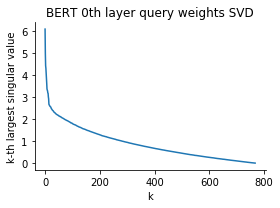

In [53]:
plt.figure(figsize=(4,3))
plt.plot(np.arange(len(S)), x.cpu().numpy())
plt.xlabel(r'k')
plt.ylabel(r'k-th largest singular value')
plt.title('BERT 0th layer query weights SVD')
sns.despine()
plt.tight_layout()
plt.savefig('figs/svd-singular-vals-distribution.png', dpi=300, bbox_inches='tight')

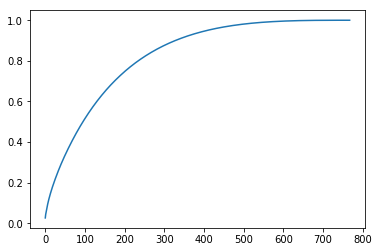

In [13]:
cumsums = (torch.cumsum(S ** 2, 0) / torch.sum(S ** 2)).cpu().numpy()

plt.plot(np.arange(len(cumsums)), cumsums);

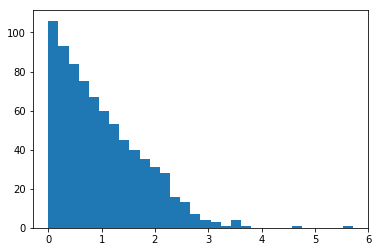

In [154]:
plt.hist(S.cpu().numpy(), bins=30);

In [64]:
(U @ torch.diag(S) @ V.t()) - mat

tensor([[ 4.2841e-08,  8.5682e-08,  2.7940e-08,  ...,  2.2724e-07,
         -5.2154e-08,  4.0978e-08],
        [ 2.9802e-08,  3.3528e-08, -3.0920e-07,  ...,  0.0000e+00,
         -1.4901e-07,  5.2620e-08],
        [-1.3132e-07, -1.0803e-07,  3.7439e-07,  ...,  8.9407e-08,
          3.0734e-07, -1.4156e-07],
        ...,
        [-1.8626e-08, -2.2352e-08, -8.1956e-08,  ...,  9.3132e-09,
          1.7509e-07, -2.1607e-07],
        [ 2.9802e-08,  1.4901e-08,  0.0000e+00,  ..., -1.3411e-07,
         -3.3528e-08,  1.5646e-07],
        [-9.3132e-08, -1.4901e-08,  3.7253e-08,  ..., -1.8626e-09,
          7.4506e-09, -6.3330e-08]], device='cuda:0')

In [156]:
import json

In [158]:
with open('output/bert_config.json', 'r') as f:
    j = json.load(f)

In [159]:
j

{'attention_probs_dropout_prob': 0.1,
 'hidden_act': 'gelu',
 'hidden_dropout_prob': 0.1,
 'hidden_size': 768,
 'initializer_range': 0.02,
 'intermediate_size': 3072,
 'max_position_embeddings': 512,
 'num_attention_heads': 12,
 'num_hidden_layers': 12,
 'type_vocab_size': 2,
 'vocab_size': 30522}